## Tarea Semanal Nro 7 | Filtrado digital lineal de ECG

#### **Introducción y fundamentos teóricos**
##### *Propuesta*

 En esta tarea semanal se analizarán técnicas no lineales de estimación/sustracción de la señal de movimiento de base $ b(n) $.

$$
\hat{x} = s - \hat{b}
$$

Siendo $ s $ la señal de ECG registrada **con interferencias**, y $ \hat{x} $ la señal filtrada, una estimación del ECG **sin interferencias**.

##### *Limitaciones del filtrado lineal*

El filtrado lineal presenta limitaciones importantes, especialmente cuando se aplica a señales no estacionarias o cuando se requiere preservar información no lineal (elimina unicamente ruido correlado). Además, no distingue entre componentes relevantes y ruido si ambos comparten el mismo rango de frecuencias, lo que puede llevar a distorsiones o pérdida de información significativa.  Por estas razones, en algunos casos se prefieren técnicas adaptativas o no lineales que puedan ajustarse mejor a las características de la señal.


In [1]:
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import medfilt
from scipy.interpolate import CubicSpline
from scipy.signal import convolve
from scipy.signal import find_peaks

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)


#### Cargo las señales a utilizar

In [2]:

# Cargar la señal ECG
fs = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')

# Extraer las señales
ecg = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs = mat_struct['qrs_pattern1'].flatten()
qrs_det = mat_struct['qrs_detections'].flatten()

# Normalización tipo z-score: (x - media) / std
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Aplicar normalización
ecg = normalize(ecg)
hb1 = normalize(hb1)
hb2 = normalize(hb2)
qrs = normalize(qrs)

# Crear un vector de tiempo para la señal ECG completa
t_ecg = np.arange(len(ecg)) / fs

# Crear vectores de tiempo para los patrones (usualmente de menor duración)
t_hb1 = np.arange(len(hb1)) / fs
t_hb2 = np.arange(len(hb2)) / fs
t_qrs = np.arange(len(qrs)) / fs



#### **Filtro de mediana**

Utilizo la función medfilt de Scipy Signal. Un filtro de mediana reemplaza cada muestra de una señal por la mediana de un conjunto de muestras vecinas (una ventana). En nuestro caso deberíamos asegurarnos que la cantidad de muestras sea mayor al tamaño que ocupa un complejo QRS para que los picos no arruinen la medición.


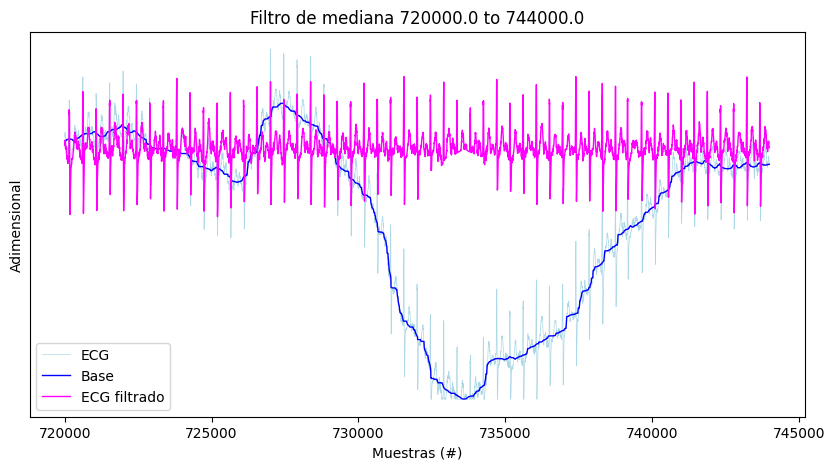

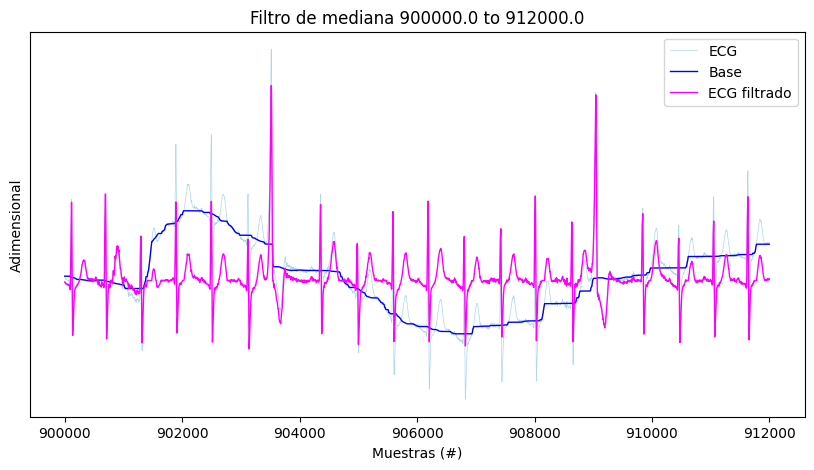

In [3]:

#########################################
########## FILTRO DE MEDIANA ##########
#########################################

# Aplica filtro de mediana con ventana de 200 muestras
trend= medfilt(ecg, kernel_size=201)

# Luego aplica filtro de mediana con ventana de 600 muestras
trend = medfilt(trend, kernel_size=601)

ecg_filtrada = ecg - trend


cant_muestras = ecg.shape[0]
fig_sz_x = 10
fig_sz_y = 5
fig_dpi = 100

regs_interes = ( 
        #np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=0.5, color='lightblue')
    plt.plot(zoom_region, trend[zoom_region], label='Base',linewidth=1,color='blue')
    plt.plot(zoom_region, ecg_filtrada[zoom_region], label='ECG filtrado',linewidth=1,color='magenta')
    plt.title('Filtro de mediana ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()



#### Observaciones

Viendo la linea de base calculada (en azul), se aprecia con algo de ruido, pequeños piquitos que podrían indicar un filtro indeseado de frecuencias rápidas del ecg (igual es mínimo). Observo la señal filtrada, la veo derecha, sin ondas lentas y con la morfología de los complejos qrs conservada.

#### **Filtro por interpolación de splines cúbicos**

A partir de qrs_detections elijo un nivel de delay para capturar un punto entre la onda P y Q. Interpolo los puntos con la funcion CubicSplines para calcular la base.

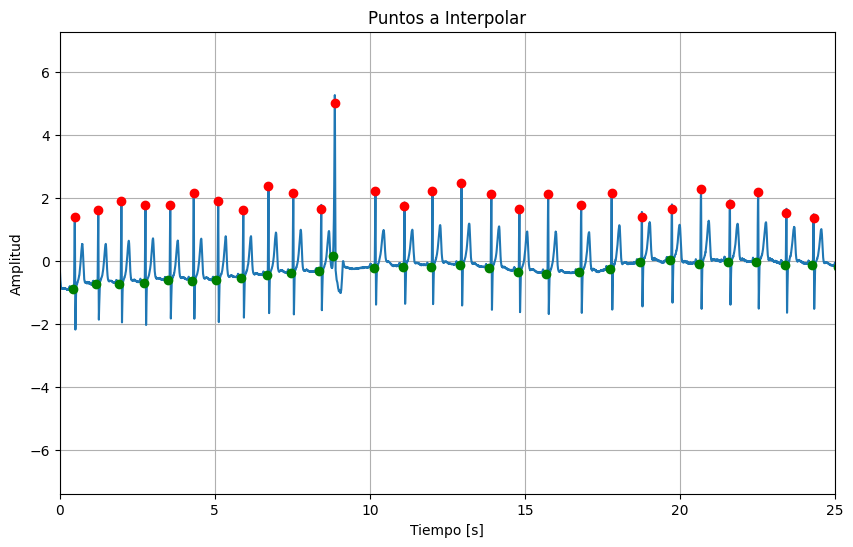

In [4]:

#########################################
## INTERPOLACIÓN CON SPLINES CÚBICOS ####
#########################################

# Definir el retraso
delay = 0.06  # segundos

puntos_inter = (qrs_det - delay * fs).astype(int)


plt.figure(figsize=(10, 6))
plt.plot(t_ecg, ecg, label='ECG Original')
plt.plot(t_ecg[qrs_det], ecg[qrs_det], 'ro', label='Picos')
plt.plot(t_ecg[puntos_inter], ecg[puntos_inter], 'go', label='Puntos a interpolar')
plt.xlim(0, 25)  # Limitar el eje x para ver mejor
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.title('Puntos a Interpolar')
plt.grid()
plt.show()


Una vez que verifiqué que los puntos corresponden a la linea de base, aplico el filtro.

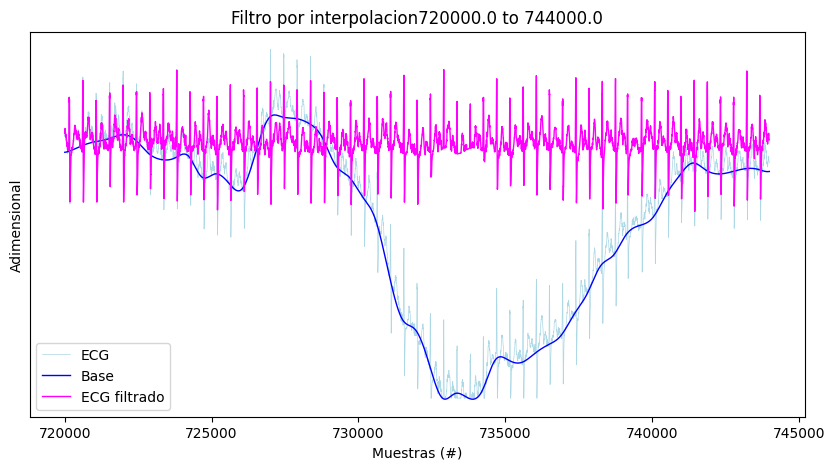

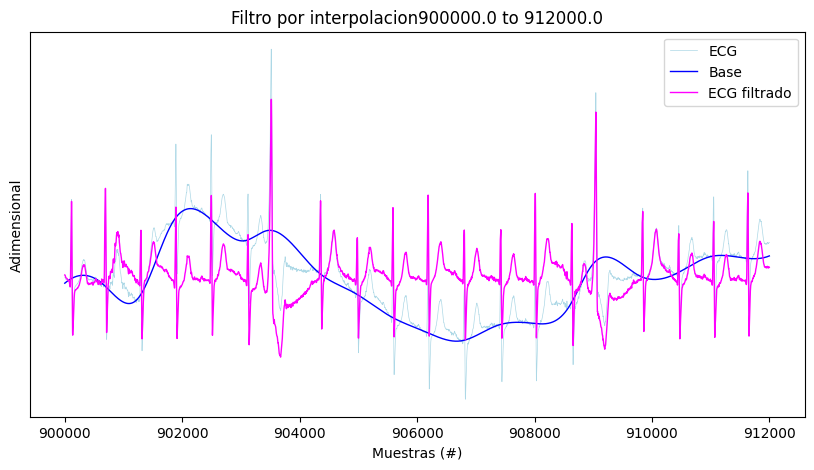

In [5]:

cs = CubicSpline(t_ecg[puntos_inter], ecg[puntos_inter])
t_cs = np.arange(len(ecg)) / fs
trend = cs(t_cs)


ecg_filtrada = ecg - trend


cant_muestras = ecg.shape[0]
fig_sz_x = 10
fig_sz_y = 5
fig_dpi = 100

regs_interes = ( 
        #np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg[zoom_region], label='ECG', linewidth=0.5, color='lightblue')
    plt.plot(zoom_region, trend[zoom_region], label='Base',linewidth=1,color='blue')
    plt.plot(zoom_region, ecg_filtrada[zoom_region], label='ECG filtrado',linewidth=1,color='magenta')
    plt.title('Filtro por interpolacion' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


#### Observaciones

En este caso la linea de base calculada (en azul) es suave por las caracteristicas propias de los splines cúbicos que aseguran derivabilidad. De esta manera nos cercioramos de que no se filtrarán frecuencias altas. Al igual que antes, observo la señal filtrada, la veo derecha, sin ondas lentas y con la morfología de los complejos qrs conservada.

#### **Filtro adaptado**

Un filtro adaptado busca un patrón específico dentro de una señal ruidosa. Funciona correlando la señal con una versión invertida del patrón: donde la correlación es máxima, se asume que el patrón está presente. De esta manera puedo detectar los latidos similares al patron de heartbeat1.


*Voy a detectar los latidos a partir de la señal filtrada por cubic splines*



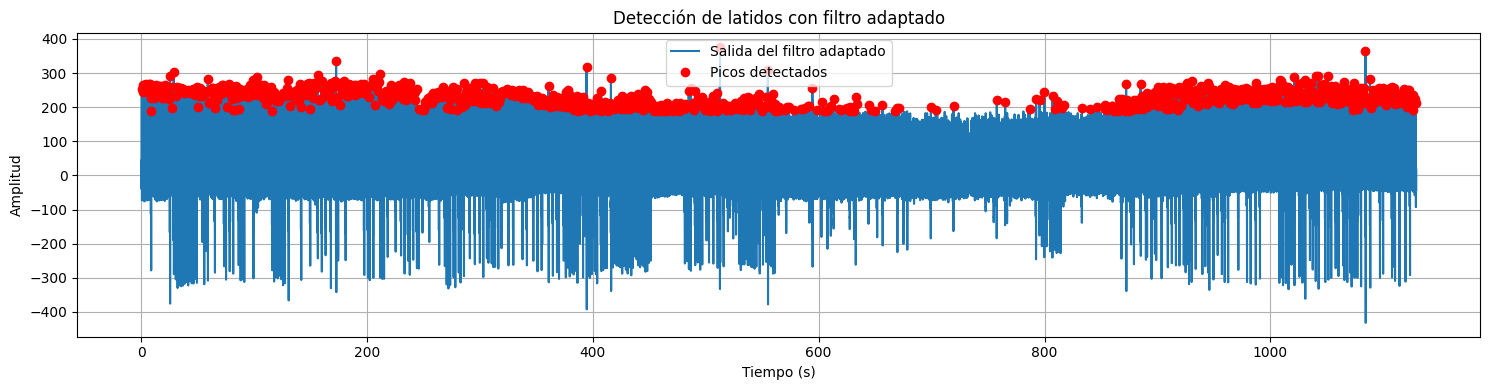

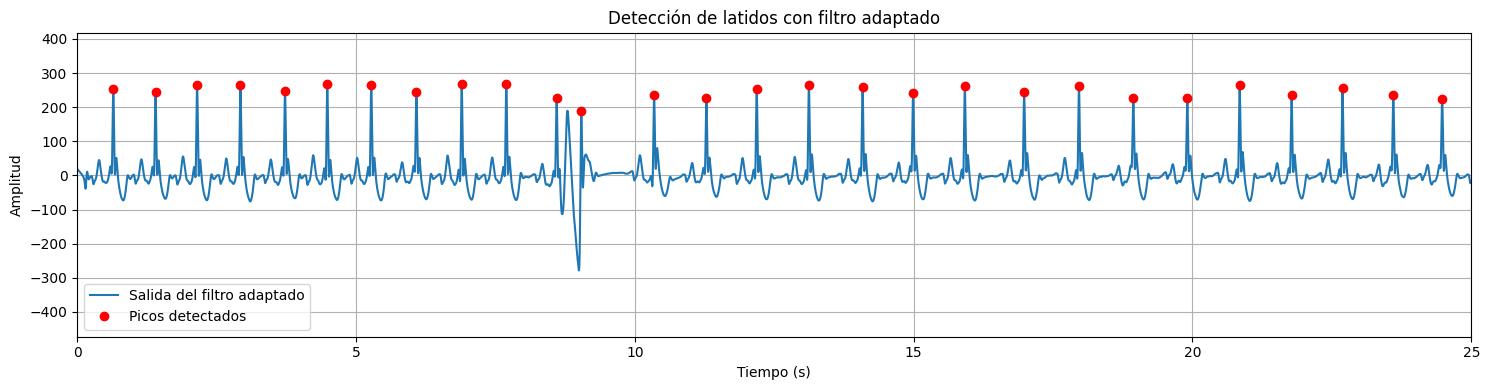

In [6]:

##########################################
######### FILTRO ADAPTADO ################
##########################################


######## Crear filtro adaptado ########


matched_filter = hb1[::-1]
ecg_ada = convolve(ecg_filtrada, matched_filter, mode='same')

########### Detectar latidos #########

peaks, _ = find_peaks(ecg_ada, height=np.max(ecg_ada) * 0.5, distance=fs*0.4)

plt.figure(figsize=(15, 4))
plt.plot(t_ecg, ecg_ada, label='Salida del filtro adaptado')
plt.plot(t_ecg[peaks], ecg_ada[peaks], 'ro', label='Picos detectados')
plt.legend()
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Detección de latidos con filtro adaptado")
plt.grid(True)
plt.tight_layout()



plt.figure(figsize=(15, 4))
plt.plot(t_ecg, ecg_ada, label='Salida del filtro adaptado')
plt.plot(t_ecg[peaks], ecg_ada[peaks], 'ro', label='Picos detectados')
plt.legend()
plt.xlim(0, 25)  # Limitar el eje x para ver mejor
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Detección de latidos con filtro adaptado")
plt.grid(True)
plt.tight_layout()
plt.show()




IMPORTANTE: El filtro va a detectar los puntos máximos entre la correlación de la señal con el patron invertido. Estos NO son los picos R de la señal registrados en qrs_detections, por eso le restó un delay de 0.165 segundos.

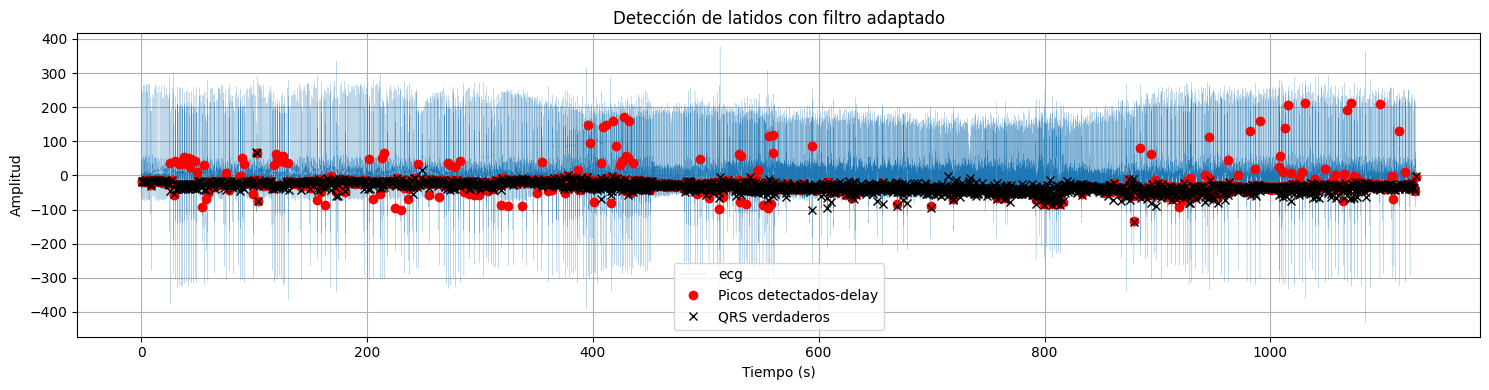

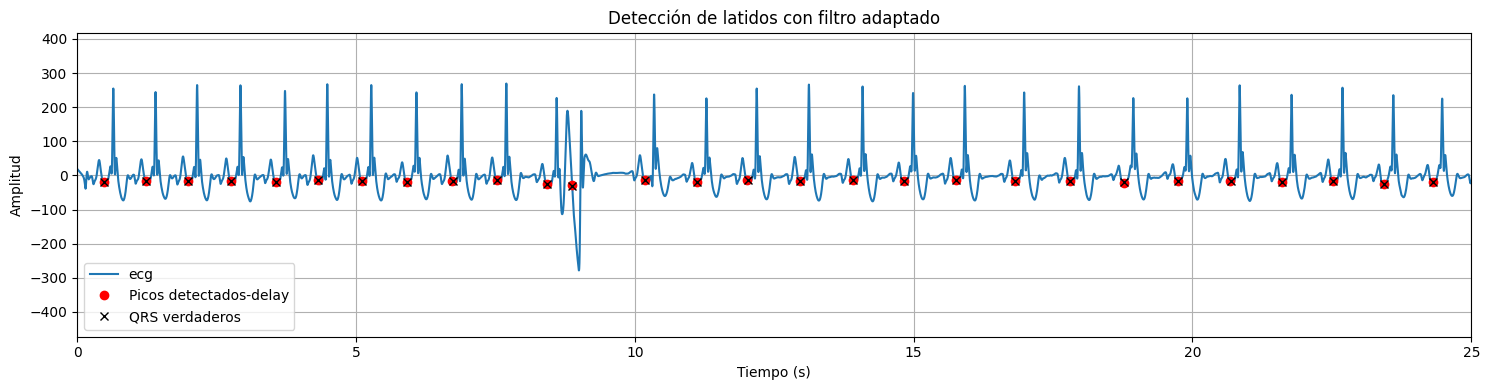

In [7]:


delay= 0.165  # segundos
peaks= (peaks - delay * fs).astype(int)
peaks = peaks[peaks > 0]


plt.figure(figsize=(15, 4))
plt.plot(t_ecg, ecg_ada, label='ecg',linewidth=0.1)
plt.plot(t_ecg[peaks], ecg_ada[peaks], 'ro', label='Picos detectados-delay')
plt.plot(t_ecg[qrs_det], ecg_ada[qrs_det], 'kx', label='QRS verdaderos')
plt.legend()
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Detección de latidos con filtro adaptado")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))
plt.plot(t_ecg, ecg_ada, label='ecg')
plt.plot(t_ecg[peaks], ecg_ada[peaks], 'ro', label='Picos detectados-delay')
plt.plot(t_ecg[qrs_det], ecg_ada[qrs_det], 'kx', label='QRS verdaderos')
plt.legend()
plt.xlim(0, 25)  # Limitar el eje x para ver mejor
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("Detección de latidos con filtro adaptado")
plt.grid(True)
plt.tight_layout()
plt.show()



#### Comprobar la efectividad del filtro 

Nivel de tolerancia = 0.085 : lo máximo que puede equivocarse mi detector de latidos.

##### Métricas calculadas:

- **Sensibilidad (Recall)**  
  Mide qué proporción de los latidos reales fueron detectados correctamente.

  $$
  \text{Sensibilidad} = \frac{\text{TP}}{\text{TP} + \text{FN}}
  $$

- **Precisión (Valor Predictivo Positivo)**  
  Mide qué proporción de las detecciones realmente eran latidos.

  $$
  \text{Precisión} = \frac{\text{TP}}{\text{TP} + \text{FP}}
  $$


In [8]:

tolerance = int(0.085 * fs)  # 50 ms de tolerancia
TP = 0
FP = 0
FN = 0

qrs_detected = np.zeros_like(qrs_det, dtype=bool)

for peak in peaks:
    if np.any(np.abs(qrs_det - peak) <= tolerance):
        TP += 1
        match_idx = np.argmin(np.abs(qrs_det - peak))
        qrs_detected[match_idx] = True
    else:
        FP += 1

FN = np.sum(~qrs_detected)

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

print(f"Sensibilidad (Recall): {sensitivity:.2f}")
print(f"Valor predictivo positivo (Precision): {precision:.2f}")

Sensibilidad (Recall): 0.41
Valor predictivo positivo (Precision): 0.77


##### Resultados: 

Sensibilidad 0.41: Indica que solo el 41% de los latidos verdaderos están siendo detectados

Precisión 0.77: Indica que el 77% de los latidos detectados son verdaderos.

#### Conlusión

El detector no es perfecto, falla principalmente en los latidos con morfologías muy diferentes al patron guía. Posibles mejoras: Usar un promedio de latidos del paciente o filtrar altas frecuencias tambián antes de utilizarlo.

### Conclusión general

Aprendí técnicas de filtrado no lineal altamente efectivas para miticar contaminación de ondas lentas de manera eficiente y sin modificar la forma de las señales biológicas como la de un ecg. Entre el filtro de mediana y la téctica de cubic splines, me quedaría con cubic splines ya que gracias a su suavidad me asegura no filtrar frecuencias altas de manera indeseada. Para un filtrado completo y prolijo aplicaría cubic splines y luego un filtro pasa bajos tipo fir (similar al de la tarea anterior, con una banda de transición no muy exigente y orden coherente). Además, diseñé un detector de latidos y lo testié con dos métricas de efectividad.

## Bonus: *¿Podría funcionar el detector basado en el filtro adaptado con un latido perteneciente a otro registro o paciente?* 

#### Entiendo que el complejo QRS es universal en pacientes sanos. Mientras el latido de otro registro o otro paciente no presente patologías, debería funcionar. Lo importante es que esté muestreado a la misma frecuencia y con la misma resolución 